In [1]:
import matplotlib.pyplot as plt
import numpy as np
import yt
from field_definitions import _nuclei_density, _electron_density
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
from astropy import units as u, constants  as const
from matplotlib.colors import LogNorm

pc = const.pc.cgs.value
kB  = const.k_B.cgs.value
Msun = const.M_sun.cgs.value
G = const.G.cgs.value
Myr = u.Myr.in_units("s")

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "text.latex.preamble" : r'\boldmath'
})

<ipython-input-1-9c68b8e7e313>:5: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,


In [2]:
default_file = "SILCC_hdf5_plt_cnt_1080"

# radius of the bubble and center
radius=100
# c = ([-80, -150, 0], "pc") # only new version of YT
c = [-80*pc, -150*pc, 0*pc]
extent = [-radius, radius, -radius, radius]


In [4]:
data = {}
Ltot_ad = {}
Ltot_sp = {}
f = ("gas", "xray_emissivity_0.1_2_keV")
l = ("gas", "xray_luminosity_0.1_2_keV")
for table in ["cloudy", "apec"]:
    ds = yt.load("sim-files/SILCC_hdf5_plt_cnt_1080")
    ad = ds.all_data()
    sp = sphere = ds.sphere(c, (radius, "pc"))
    # register data fields
    ds.add_field(('gas', 'H_nuclei_density'), _nuclei_density, sampling_type="local", units="cm**(-3)", force_override=True)
    ds.add_field(('gas', 'El_number_density'), _nuclei_density, sampling_type="local", units="cm**(-3)", force_override=True)    
    #ds.add_field(('gas', 'electron_density'), _electron_density, sampling_type="local", units="g*cm**(-3)", force_override=True)

    yt.add_xray_emissivity_field(ds, 0.1, 2, metallicity=1.0, data_dir="/Users/girichidis/Physics/Tables/yt-python/", table_type=table)

    data[table] = np.array(yt.SlicePlot(ds, "z", center=c, fields=f).data_source.to_frb((2*radius, 'pc'), 1024)[f])

    Ltot_ad[table] = np.sum(ad[l])
    Ltot_sp[table] = np.sum(sp[l])
print(Ltot_ad)
print(Ltot_sp)

yt : [INFO     ] 2025-02-21 10:12:12,374 Parameters: current_time              = 340597785179995.1
yt : [INFO     ] 2025-02-21 10:12:12,375 Parameters: domain_dimensions         = [8 8 8]
yt : [INFO     ] 2025-02-21 10:12:12,377 Parameters: domain_left_edge          = [-7.715e+20 -7.715e+20 -7.715e+20]
yt : [INFO     ] 2025-02-21 10:12:12,378 Parameters: domain_right_edge         = [7.715e+20 7.715e+20 7.715e+20]
yt : [INFO     ] 2025-02-21 10:12:12,378 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2025-02-21 10:12:19,270 Loading emissivity data from /Users/girichidis/Physics/Tables/yt-python/cloudy_emissivity_v2.h5
yt : [INFO     ] 2025-02-21 10:12:19,276 X-ray emissivity data calculated with Cloudy 13 rc1 on 12/10/2012 by Britton Smith.
yt : [INFO     ] 2025-02-21 10:12:19,277 X-ray 'cloudy' emissivity data version: 2.
yt : [INFO     ] 2025-02-21 10:12:19,292 Adding ('gas','xray_emissivity_0.1_2_keV') field.
yt : [INFO     ] 2025-02-21 10:12:19,293 Adding ('gas','xray_lu

{'cloudy': unyt_quantity(1.06600964e+36, 'erg/s'), 'apec': unyt_quantity(2.25008457e+36, 'erg/s')}
{'cloudy': unyt_quantity(9.89992666e+35, 'erg/s'), 'apec': unyt_quantity(2.10157584e+36, 'erg/s')}


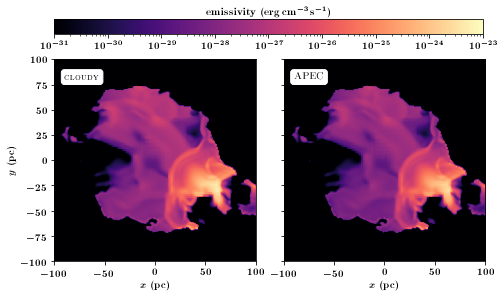

In [5]:
fig = plt.figure(figsize=(7,7))

ax = fig.add_axes([0,0,0.4,0.4])
im = ax.imshow(np.clip(data["apec"],1e-31,None), cmap="magma", origin="lower", \
                           extent=extent, norm=LogNorm(vmin=1e-31, vmax=1e-23))
ax.set_xlabel("$x~(\\mathrm{pc})$")
ax.set_ylabel("$y~(\\mathrm{pc})$")
ax.text(-90,80,"\\textsc{cloudy}", \
                    bbox=dict(facecolor='white', edgecolor='white', boxstyle='round', alpha=1))


ax = fig.add_axes([0.455,0.0,0.4,0.4])
ax.set_yticklabels([])
im = ax.imshow(np.clip(data["cloudy"],1e-31,None), cmap="magma", origin="lower", \
                           extent=extent, norm=LogNorm(vmin=1e-31, vmax=1e-23))
ax.set_xlabel("$x~(\\mathrm{pc})$")
ax.text(-90,80,"\\textsc{APEC}", \
                    bbox=dict(facecolor='white', edgecolor='white', boxstyle='round', alpha=1))

cbar_axes = fig.add_axes([0.0,0.45,0.85,0.03])
cbar = plt.colorbar(im, cax=cbar_axes, orientation="horizontal", \
                    label="\\textbf{emissivity }$(\\mathrm{erg\\,cm^{-3}\\,s^{-1}})$")
cbar.ax.xaxis.set_label_position("top")

fig.savefig("plots/comparison-tables-maps.pdf", bbox_inches="tight")

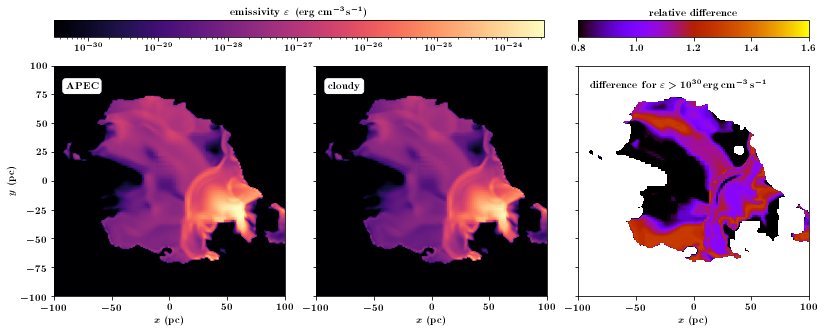

In [12]:
vmin = 1e-30/3.
vmax = 1e-23/3.

# plot also relative changes
fig = plt.figure(figsize=(8,8))

# panel 1
ax = fig.add_axes([0,0,0.4,0.4])
im = ax.imshow(np.clip(data["apec"],vmin,None), cmap="magma", origin="lower", \
                           extent=extent, norm=LogNorm(vmin=vmin, vmax=vmax))
ax.set_xlabel("$x~(\\mathrm{pc})$")
ax.set_ylabel("$y~(\\mathrm{pc})$")
ax.text(-90,80,"\\textbf{\\textsc{APEC}}", \
                    bbox=dict(facecolor='white', edgecolor='white', boxstyle='round', alpha=1))
# panel 2
ax = fig.add_axes([0.455,0.0,0.4,0.4])
ax.set_yticklabels([])
im = ax.imshow(np.clip(data["cloudy"],vmin,None), cmap="magma", origin="lower", \
                           extent=extent, norm=LogNorm(vmin=vmin, vmax=vmax))
ax.set_xlabel("$x~(\\mathrm{pc})$")
ax.text(-90,80,"\\textbf{\\textsc{cloudy}}", \
                    bbox=dict(facecolor='white', edgecolor='white', boxstyle='round', alpha=1))

# colorbar 1 spanning panel 1 & 2
cbar_axes = fig.add_axes([0.0,0.45,0.85,0.03])
cbar = plt.colorbar(im, cax=cbar_axes, orientation="horizontal", \
                    label="\\textbf{emissivity }$\\varepsilon~~(\\mathrm{erg\\,cm^{-3}\\,s^{-1}})$")
cbar.ax.xaxis.set_label_position("top")

# panel 3
ax = fig.add_axes([0.455+0.4+0.055,0,0.4,0.4])
ax.set_yticklabels([])

plt_min = 1e-30
#cl_data = np.clip(data["cloudy"], plt_min, None)
#idx = np.where(data["cloudy"] > 1.1*plt_min)
#rel_diff = np.ones_like(data["cloudy"])*plt_min
#rel_diff[idx] = (np.abs(data["cloudy"]-data["apec"])/data["cloudy"])[idx]

rel_diff = np.zeros_like(data["cloudy"])*np.nan
idx = np.where(data["cloudy"] > 1.1*plt_min)
rel_diff[idx] = (np.abs(data["cloudy"]-data["apec"])/data["cloudy"])[idx]


im = ax.imshow(rel_diff, cmap="gnuplot", origin="lower", \
                           extent=extent, vmin=0.8, vmax=1.6)
ax.set_xlabel("$x~(\\mathrm{pc})$")
ax.text(-90,80,"\\textbf{difference for }$\\varepsilon>10^{30}\\,\\mathrm{erg\\,cm^{-3}\\,s^{-1}}$", \
                    bbox=dict(facecolor='white', edgecolor='white', boxstyle='round', alpha=1))

# colorbar 1 spanning panel 1 & 2
cbar_axes = fig.add_axes([0.455+0.4+0.055,0.45,0.4,0.03])
cbar = plt.colorbar(im, cax=cbar_axes, orientation="horizontal", \
                    label="\\textbf{relative difference }")
cbar.ax.xaxis.set_label_position("top")

fig.savefig("plots/comparison-tables-maps-plus-diff.pdf", bbox_inches="tight")
